# Credit Card Application Model

We'll start by preprocessing the data

## Section 1 Preprocessing

In [1]:
import pandas as pd
import numpy as np
import pandas as pd   
import seaborn as sns
from xgboost import XGBClassifier
import sys
%matplotlib inline
import matplotlib.pyplot as plt
applicationRecord = pd.read_csv('application_record.csv')
creditRecord = pd.read_csv('credit_record.csv')

#Get counts of application record and credit record
print("Credit Labels")
print(creditRecord.count())
print("application Labels \n")
print(applicationRecord.count())
#!{sys.executable} -m pip install imbalanced-learn delayed


Credit Labels
ID                1048575
MONTHS_BALANCE    1048575
STATUS            1048575
dtype: int64
application Labels 

ID                     438557
CODE_GENDER            438557
FLAG_OWN_CAR           438557
FLAG_OWN_REALTY        438557
CNT_CHILDREN           438557
AMT_INCOME_TOTAL       438557
NAME_INCOME_TYPE       438557
NAME_EDUCATION_TYPE    438557
NAME_FAMILY_STATUS     438557
NAME_HOUSING_TYPE      438557
DAYS_BIRTH             438557
DAYS_EMPLOYED          438557
FLAG_MOBIL             438557
FLAG_WORK_PHONE        438557
FLAG_PHONE             438557
FLAG_EMAIL             438557
OCCUPATION_TYPE        304354
CNT_FAM_MEMBERS        438557
dtype: int64


What we just did was check the record of each file and as we can see there are way more records in Credit than in application. This is due to the fact of how credit record it set up meaning while, ID is represents different customers they have a row for each month their account has been open.

### Observations

There exist two obvious issues:
1. The number of application records is less than the number of credit records
2. The OCCUPATION_TYPE column has less values than the rest of the columns (suggesting NA values in play)



In [2]:
#First we'll look at our columns before the drop
print("application columns")
print(applicationRecord.columns)


application columns
Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')


### What next?

Now that we have the only columns we need, we can merge the two dataframes called "comprehensive", which includes the columns of both dataframes while also aligning the data from one ID to its corresponding data from both datasets

In [3]:
comprehensive = pd.merge(applicationRecord, creditRecord)
comprehensive.shape

(777715, 20)

Here we merge the two files which should merge based on IDs and get rid of any IDs not in both files

### Observations
We have multiple entries for the same person, which is important to keep for the sake of better understanding when we throw the data into an unsupervised ML model. We may be able to gain insight into something like their balance or status in relation to some other data point we haven't yet considered. 

Moving from this,  our "DAYS_BIRTH" column is incredibly unintuitive for humans to read, so our next step will be to convert it to years. And because the we don't care about fractions of a year, we'll use floor division. Here we also turn days_employed into years employed with the ceil function

In [4]:
#Divide the DAYS_BIRTH to years for our use
import numpy as np
comprehensive["DAYS_BIRTH"] = comprehensive["DAYS_BIRTH"].div(-365.2425)
comprehensive["DAYS_EMPLOYED"] = comprehensive["DAYS_EMPLOYED"].div(-365.2425)\

#We divided by -365 to get the values from negative to positive

In [5]:
#Rename DAYS_BIRTH to YEARS_OLD
comprehensive = comprehensive.rename(columns={"DAYS_BIRTH":"YEARS_OLD"})
comprehensive = comprehensive.rename(columns={"DAYS_EMPLOYED":"YEARS_EMPLOYED"})

### Now what?
Let's check for null values

In [6]:
comprehensive.isnull().sum()
comprehensive['OCCUPATION_TYPE'].fillna(value='Not identified', inplace=True)
# we drop this beacuse it is all ones anyway so it is unneeded
comprehensive = comprehensive.drop(columns=["FLAG_MOBIL" ])

comprehensive.loc[(comprehensive['YEARS_EMPLOYED'] <= 0), 'OCCUPATION_TYPE'] = 'Unemployed'

# Checking for outliers

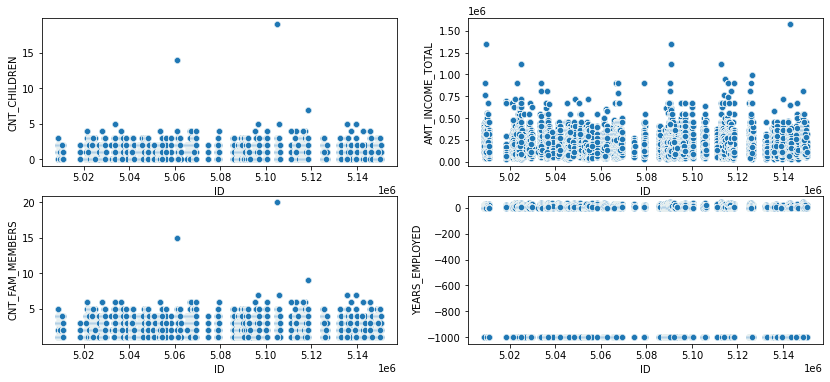

In [7]:
fig, ax= plt.subplots(nrows= 2, ncols = 2, figsize= (14,6))
sns.scatterplot(x='ID', y='CNT_CHILDREN', data=comprehensive, ax=ax[0][0])
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=comprehensive, ax=ax[0][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=comprehensive, ax=ax[1][0])
sns.scatterplot(x='ID', y='YEARS_EMPLOYED', data=comprehensive, ax=ax[1][1])
q_hi = comprehensive['CNT_CHILDREN'].quantile(0.999)
q_low = comprehensive['CNT_CHILDREN'].quantile(0.001)
comprehensive = comprehensive[(comprehensive['CNT_CHILDREN']>q_low) & (comprehensive['CNT_CHILDREN']<q_hi)]
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = comprehensive['AMT_INCOME_TOTAL'].quantile(0.999)
q_low = comprehensive['AMT_INCOME_TOTAL'].quantile(0.001)
comprehensive= comprehensive[(comprehensive['AMT_INCOME_TOTAL']>q_low) & (comprehensive['AMT_INCOME_TOTAL']<q_hi)]
#FOR CNT_FAM_MEMBERS COLUMN
q_hi = comprehensive['CNT_FAM_MEMBERS'].quantile(0.999)
q_low = comprehensive['CNT_FAM_MEMBERS'].quantile(0.001)
comprehensive= comprehensive[(comprehensive['CNT_FAM_MEMBERS']>q_low) & (comprehensive['CNT_FAM_MEMBERS']<q_hi)]

<AxesSubplot:xlabel='ID', ylabel='YEARS_EMPLOYED'>

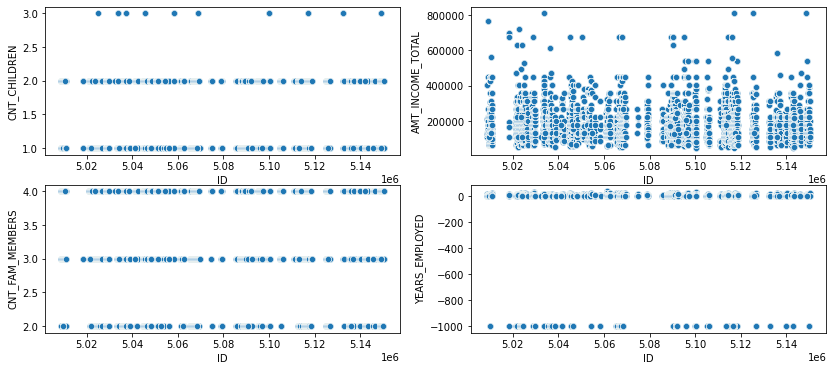

In [8]:
fig, ax= plt.subplots(nrows= 2, ncols = 2, figsize= (14,6))
sns.scatterplot(x='ID', y='CNT_CHILDREN', data=comprehensive, ax=ax[0][0])
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=comprehensive, ax=ax[0][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=comprehensive, ax=ax[1][0])
sns.scatterplot(x='ID', y='YEARS_EMPLOYED', data=comprehensive, ax=ax[1][1])

# Checking Name_Income_ type misclassified

['Working' 'Commercial associate' 'State servant' 'Pensioner' 'Student']


array([[<AxesSubplot:title={'center':'Commercial associate'}>,
        <AxesSubplot:title={'center':'Pensioner'}>],
       [<AxesSubplot:title={'center':'State servant'}>,
        <AxesSubplot:title={'center':'Student'}>],
       [<AxesSubplot:title={'center':'Working'}>, <AxesSubplot:>]],
      dtype=object)

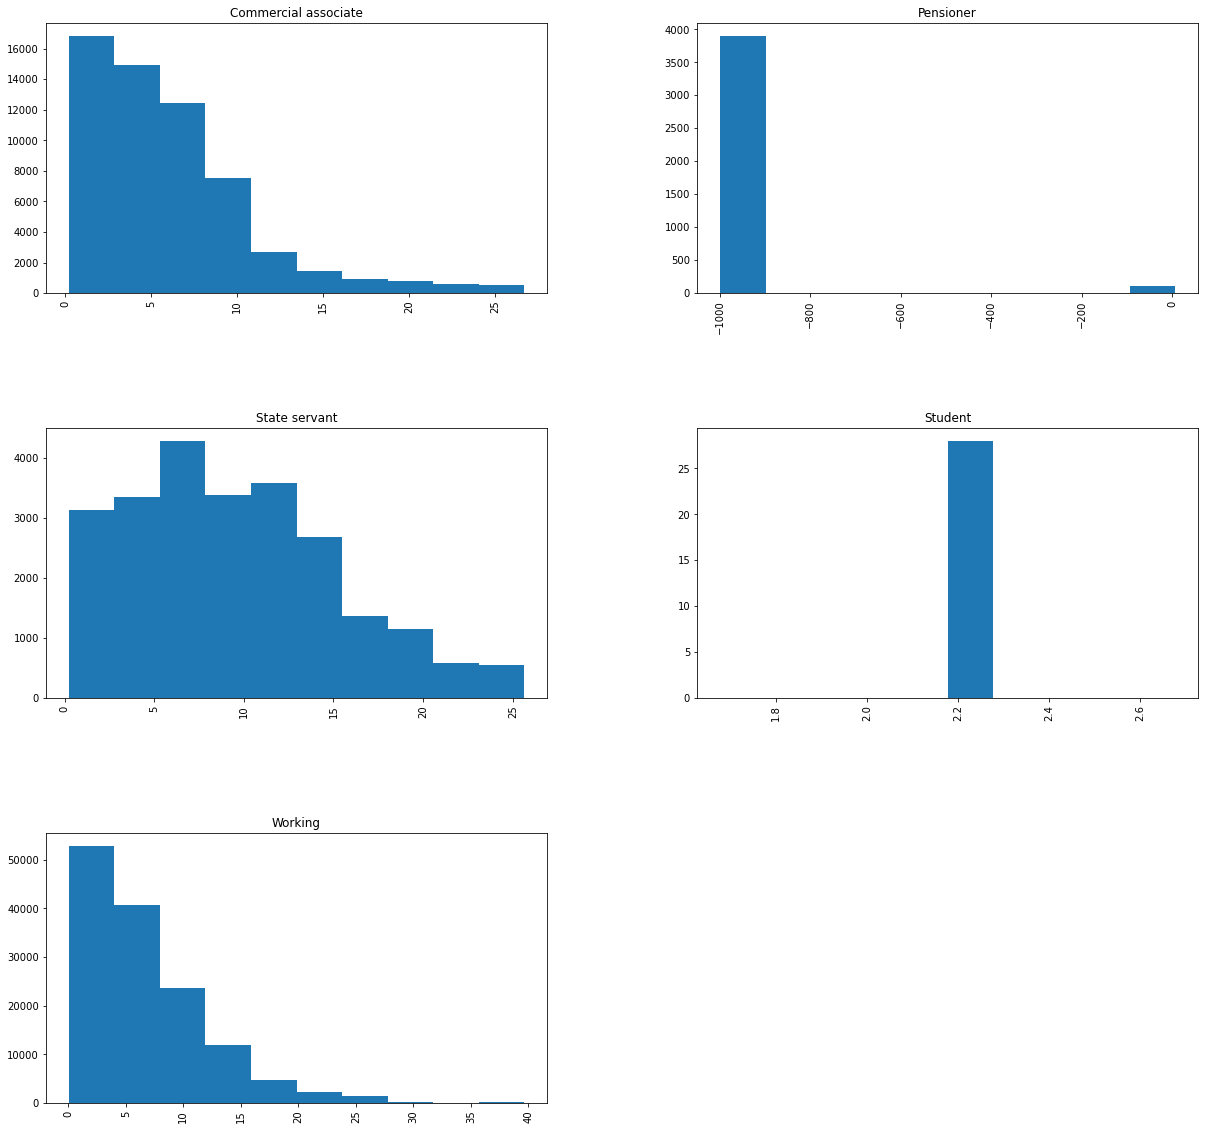

In [9]:

print(comprehensive['NAME_INCOME_TYPE'].unique())
comprehensive[['NAME_INCOME_TYPE','YEARS_EMPLOYED']].hist(by='NAME_INCOME_TYPE', figsize=(20, 20))

Here we can clearly see that pensioners are set to this value that is suppposed to be impossible, so instead we can instead change the pensioners days employed to zero instead of eliminating those data points. Besides that we should also change days employed to years, with to the closest year as the exact date of employment is less known by users(unsure if we should do this). Also maybe want to either label encode or one hot encode the flag values for more data processing

array([[<AxesSubplot:title={'center':'Commercial associate'}>,
        <AxesSubplot:title={'center':'Pensioner'}>],
       [<AxesSubplot:title={'center':'State servant'}>,
        <AxesSubplot:title={'center':'Student'}>],
       [<AxesSubplot:title={'center':'Working'}>, <AxesSubplot:>]],
      dtype=object)

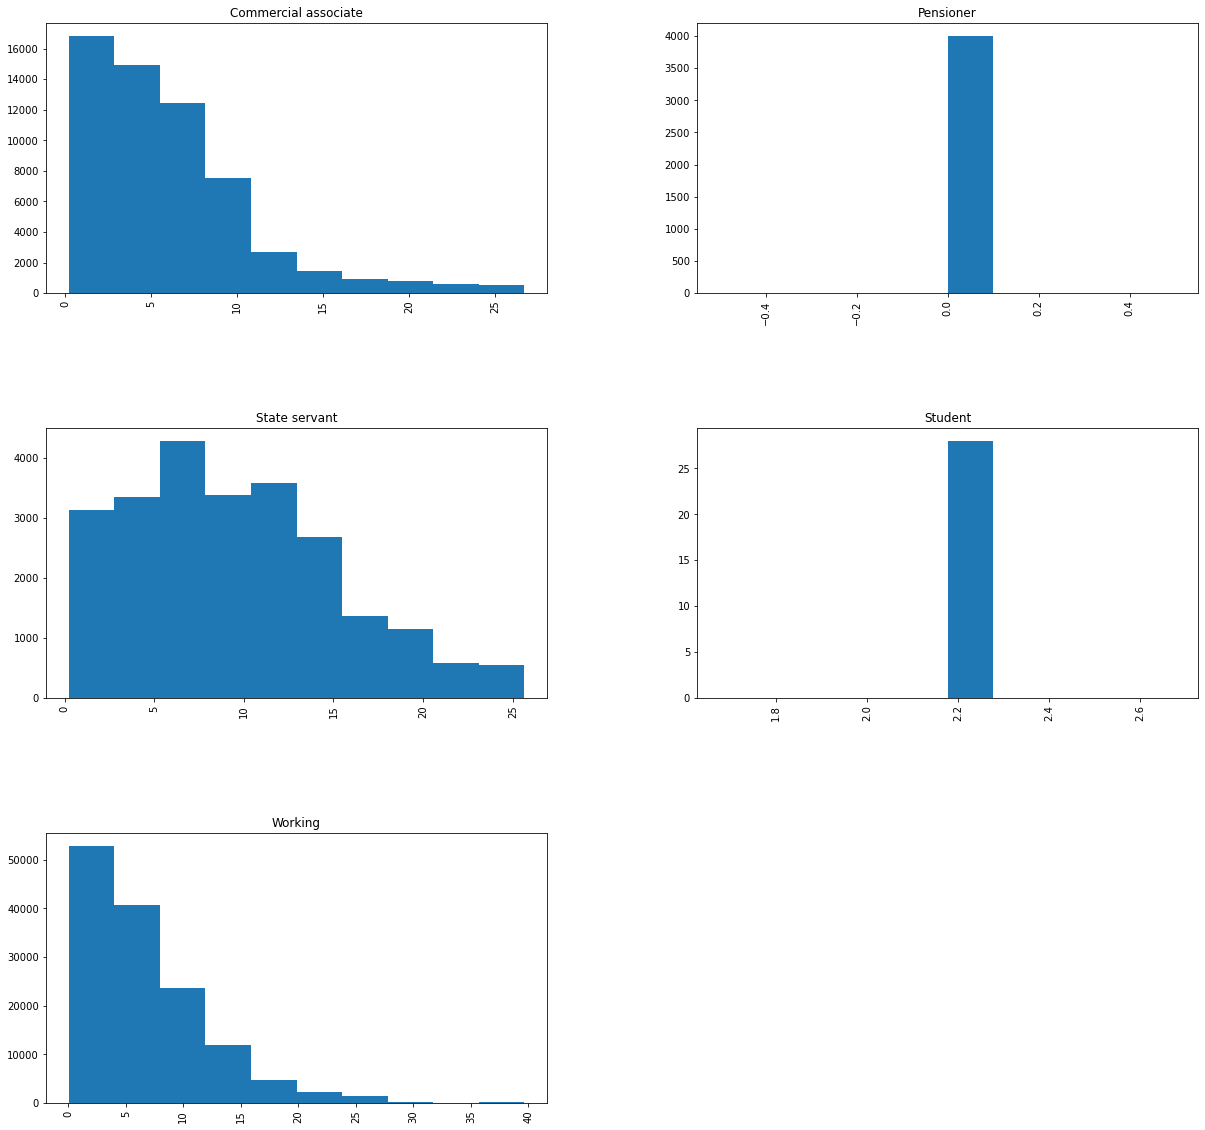

In [10]:
comprehensive.loc[(comprehensive['NAME_INCOME_TYPE'] == "Pensioner"), 'YEARS_EMPLOYED'] = 0
# If their income is a pensioner their occupation type is unemployed
comprehensive.loc[(comprehensive['NAME_INCOME_TYPE'] == "Pensioner"), 'OCCUPATION_TYPE'] = 'Unemployed'
comprehensive[['NAME_INCOME_TYPE','YEARS_EMPLOYED']].hist(by='NAME_INCOME_TYPE', figsize=(20, 20))

# Creation Approval which we will predict #
# also collapsing the data to one row per ID #

In [11]:

My_credit_Dict = {'C' : 2,
               'X' : 1,
               '0' : -1,
               '1' : -2,
               '2' : -3,
               '3' : -4,
               '4' : -5,
               '5' : -6}
comprehensive.replace({'STATUS' : My_credit_Dict }, inplace=True)
new_filtered_credit = comprehensive.value_counts(subset=['ID', 'STATUS']).unstack(fill_value=0)

new_filtered_credit.loc[2*(new_filtered_credit[2]+new_filtered_credit[1]-(new_filtered_credit[-1]+(2*new_filtered_credit[-2])+(3*new_filtered_credit[-3]) >= 0)+(4*new_filtered_credit[-4])+(5*new_filtered_credit[-5])+(6*new_filtered_credit[-6])) >= 0, 'APPROVAL_STATUS'] = 1
new_filtered_credit.loc[2*(new_filtered_credit[2]+new_filtered_credit[1]-(new_filtered_credit[-1]+(2*new_filtered_credit[-2])+(3*new_filtered_credit[-3]) >= 0)+(4*new_filtered_credit[-4])+(5*new_filtered_credit[-5])+(6*new_filtered_credit[-6])) < 0, 'APPROVAL_STATUS'] = 0

comprehensive = comprehensive.drop_duplicates(subset=['ID'], keep='last')
new_filtered_credit = new_filtered_credit.drop(columns=[-6,-5,-4,-3,-2,-1,2,1])



Here we just had a created target label out of the late payments. and created them into unqiue IDs and next we will combine them.

In [12]:
comprehensive=comprehensive.merge(new_filtered_credit, how='left', on='ID')
comprehensive.drop(columns=['STATUS'],inplace=True)
#comprehensive

# One Hot Encode  and deleting duplicate data #

In [13]:

oneHotDF= pd.get_dummies(comprehensive[['FLAG_OWN_CAR','FLAG_OWN_REALTY',"CODE_GENDER", 
                                          "FLAG_WORK_PHONE", 
                                          "FLAG_PHONE",
                                          "FLAG_EMAIL",
                                          "CNT_FAM_MEMBERS"]], drop_first=True)
comprehensive.drop(columns = ['ID','FLAG_OWN_CAR','FLAG_OWN_REALTY',"CODE_GENDER", 
                                          "FLAG_WORK_PHONE", 
                                          "FLAG_PHONE",
                                          "FLAG_EMAIL",
                                          "CNT_FAM_MEMBERS"], inplace = True)
comprehensive_cont=comprehensive
comprehensive=comprehensive.join(oneHotDF)

oneHotDF= pd.get_dummies(comprehensive[['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']])
comprehensive.drop(columns = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE'], inplace = True)
comprehensive_cont=comprehensive
comprehensive=comprehensive.join(oneHotDF)
comprehensive["MONTHS_BALANCE"] = comprehensive["MONTHS_BALANCE"].div(-1.0)
#print(comprehensive.duplicated(subset=comprehensive.columns[:]).unique())
#print(comprehensive.duplicated(subset=comprehensive.columns[1:]).value_counts())
comprehensive =comprehensive.drop_duplicates(subset=comprehensive.columns[1:], keep='first', inplace=False)
comprehensive.to_csv('mergedApplicationCreditRecords.csv')
print("comprehensive Labels \n")
print(comprehensive.count())
print(comprehensive.shape)
#print(comprehensive)

comprehensive Labels 

CNT_CHILDREN                                         9596
AMT_INCOME_TOTAL                                     9596
YEARS_OLD                                            9596
YEARS_EMPLOYED                                       9596
MONTHS_BALANCE                                       9596
APPROVAL_STATUS                                      9596
FLAG_WORK_PHONE                                      9596
FLAG_PHONE                                           9596
FLAG_EMAIL                                           9596
CNT_FAM_MEMBERS                                      9596
FLAG_OWN_CAR_Y                                       9596
FLAG_OWN_REALTY_Y                                    9596
CODE_GENDER_M                                        9596
NAME_INCOME_TYPE_Commercial associate                9596
NAME_INCOME_TYPE_Pensioner                           9596
NAME_INCOME_TYPE_State servant                       9596
NAME_INCOME_TYPE_Student                         

In [14]:
print(comprehensive["FLAG_OWN_CAR_Y"])
print(comprehensive)

0        0
2        0
3        0
4        0
5        0
        ..
10699    0
10700    0
10701    0
10702    0
10703    1
Name: FLAG_OWN_CAR_Y, Length: 9596, dtype: uint8
       CNT_CHILDREN  AMT_INCOME_TOTAL  YEARS_OLD  YEARS_EMPLOYED  \
0                 1          112500.0  30.029364        4.435409   
2                 1          405000.0  32.422295        5.519621   
3                 1          405000.0  32.422295        5.519621   
4                 1          405000.0  32.422295        5.519621   
5                 1          405000.0  32.422295        5.519621   
...             ...               ...        ...             ...   
10699             1          180000.0  29.175137        2.535302   
10700             1          180000.0  29.175137        2.535302   
10701             1          216000.0  35.444944        6.620259   
10702             1          256500.0  48.170736        3.600348   
10703             1          450000.0  26.960170        1.374429   

       MONTHS

# Attempted PCA feature importance #
MIGHT DELETE( prorbably will )

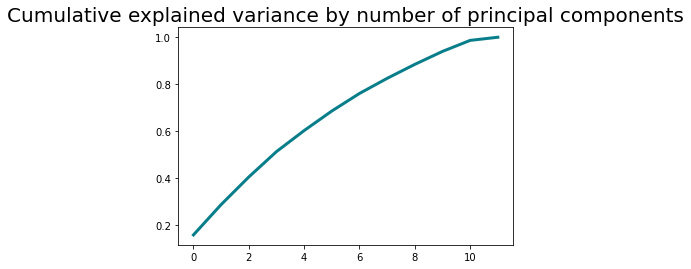

            Attribute  CorrelationWithPC1
0     CNT_FAM_MEMBERS            0.672085
1        CNT_CHILDREN            0.654547
2       CODE_GENDER_M            0.181460
3     FLAG_WORK_PHONE            0.180697
4      FLAG_OWN_CAR_Y            0.163890
5          FLAG_PHONE            0.088581
6    AMT_INCOME_TOTAL            0.004656
7      YEARS_EMPLOYED           -0.009583
8      MONTHS_BALANCE           -0.035819
9   FLAG_OWN_REALTY_Y           -0.062585
10         FLAG_EMAIL           -0.073338
11          YEARS_OLD           -0.094302


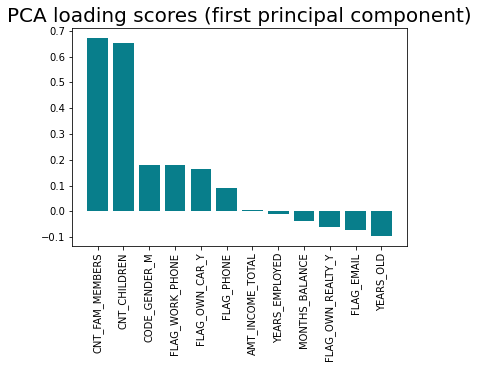

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import operator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics


train, test = train_test_split(comprehensive_cont, test_size=0.2, random_state=2)
scaler = preprocessing.StandardScaler()

X_train, y_train =  train.loc[:, train.columns != 'APPROVAL_STATUS'], train['APPROVAL_STATUS']
X_test, y_test = test.loc[:, test.columns != 'APPROVAL_STATUS'], test['APPROVAL_STATUS']
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()
loadings = pd.DataFrame(
    data=pca.components_.T, 
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)

pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']
print(pc1_loadings)
plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Split Data Set 80/20 and Standard Scaler #

In [16]:

train, test = train_test_split(comprehensive, test_size=0.2, random_state=2)
scaler = preprocessing.StandardScaler()

X_train, y_train =  train.loc[:, train.columns != 'APPROVAL_STATUS'], train['APPROVAL_STATUS']
X_test, y_test = test.loc[:, test.columns != 'APPROVAL_STATUS'], test['APPROVAL_STATUS']
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#print(y_train.value_counts())



      CNT_CHILDREN  AMT_INCOME_TOTAL  YEARS_OLD  YEARS_EMPLOYED  \
5220             1          112500.0  37.073999        9.382807   
4896             1          112500.0  27.776067        3.082883   
7100             1           67500.0  49.668371       14.259020   
5415             1          292500.0  36.370357       12.153569   
3001             1          180000.0  25.848580        3.381315   
...            ...               ...        ...             ...   
1228             1          135000.0  42.916692        0.835062   
2799             2          202500.0  32.411343        2.184850   
7420             1          135000.0  47.190565        1.177300   
2868             1          126000.0  31.379152        3.296440   
8187             2          126000.0  45.087853        9.046045   

      MONTHS_BALANCE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
5220            34.0                0           0           0   
4896            45.0                0           0           0   


In [37]:
print(X_train_scaled)

[[-0.66236466 -0.8211486  -0.00474694 ... -0.11945967 -0.14867367
  -0.07417346]
 [-0.66236466 -0.8211486  -1.32734034 ... -0.11945967 -0.14867367
  -0.07417346]
 [-0.66236466 -1.28383114  1.78675178 ... -0.11945967 -0.14867367
  -0.07417346]
 ...
 [-0.66236466  0.4691862   0.16107883 ... -0.11945967 -0.14867367
  -0.07417346]
 [-0.66236466  0.18068768 -1.31885307 ... -0.11945967 -0.14867367
  -0.07417346]
 [-0.45420866 -0.31334476  0.29914595 ... -0.11945967 -0.14867367
  -0.07417346]]


# Over sample with SMOTE #

In [17]:
from imblearn.over_sampling import SMOTE
X_train_scaled, y_train = SMOTE(random_state=1).fit_resample(X_train_scaled, y_train)

#print(y_train.value_counts())
#print(y_test.value_counts())
trains_scores=[]
tests_scores=[]

# Logestic Regression #
Here we hyper tuned it and we will see a lot of warnings after the hyper tunning as some solvers do not use some penalties, leading to errors.

test set
              precision    recall  f1-score   support

         0.0       0.28      0.77      0.42       292
         1.0       0.94      0.65      0.77      1628

    accuracy                           0.67      1920
   macro avg       0.61      0.71      0.59      1920
weighted avg       0.84      0.67      0.72      1920

training set
              precision    recall  f1-score   support

         0.0       0.69      0.77      0.73      6554
         1.0       0.74      0.66      0.70      6554

    accuracy                           0.71     13108
   macro avg       0.72      0.71      0.71     13108
weighted avg       0.72      0.71      0.71     13108

[0.7138388770216662]
[0.6703125]
0.9412992939945561


C:\Users\patch\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


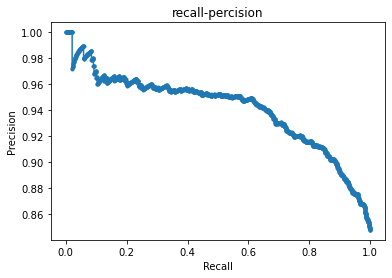

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# best param from tuning
model = LogisticRegression(C=0.08858667904100823, penalty='l1', solver='saga')
#model = LogisticRegression()
#param_grid = [    
    #{'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    #'C' : np.logspace(-4, 4, 20),
    #'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    #'max_iter' : [100, 1000,2500]
    #}
#]

#model = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=2, n_jobs=-1)
model.fit(X_train_scaled, y_train)

y_train_pred_LR = model.predict(X_train_scaled)

y_test_pred_LR = model.predict(X_test_scaled)

print("test set")
print(classification_report(y_test, y_test_pred_LR))
print("training set")
print(classification_report(y_train, y_train_pred_LR))
trains_scores.append(model.score(X_train_scaled, y_train))
tests_scores.append(model.score(X_test_scaled, y_test))
print(trains_scores)
print(tests_scores)
#print(model.best_estimator_)
prediction = model.predict_proba(X_test_scaled)[:,1]
print(average_precision_score(y_test, prediction))

precision, recall, th = precision_recall_curve(y_test, prediction)
plt.plot(recall, precision, marker='.')


plt.plot
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("recall-percision")

plt.show()

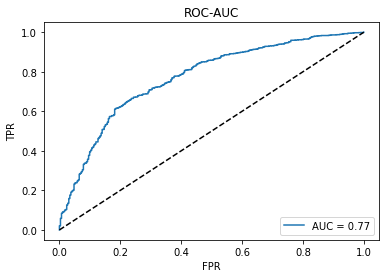

In [19]:
precision, recall, th = metrics.roc_curve(y_test, prediction)
roc_auc = metrics.auc(precision, recall)
display = metrics.RocCurveDisplay(fpr=precision, tpr=recall, roc_auc=roc_auc)

display.plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC")

plt.show()

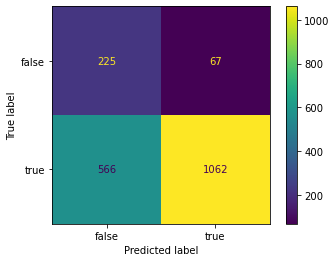

In [20]:
ConfMatrix = confusion_matrix(y_test, y_test_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=ConfMatrix, display_labels=['false','true'])
disp.plot()

# Gradient boosted decision tree #

C:\Users\patch\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:34:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.47      0.34      0.39       292
         1.0       0.89      0.93      0.91      1628

    accuracy                           0.84      1920
   macro avg       0.68      0.63      0.65      1920
weighted avg       0.82      0.84      0.83      1920

[0.7138388770216662, 0.9596429661275557]
[0.6703125, 0.8411458333333334]
0.9478778826395182


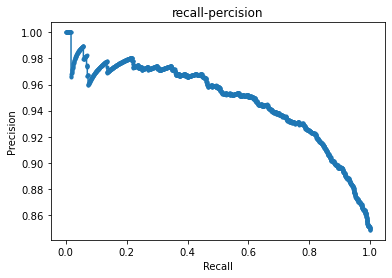

In [21]:

xgb = XGBClassifier()

modelxgb = xgb.fit(X_train_scaled, y_train)
XGBprediction = modelxgb.predict(X_test_scaled)
print(classification_report(y_test, XGBprediction))
trains_scores.append(modelxgb.score(X_train_scaled, y_train))
tests_scores.append(modelxgb.score(X_test_scaled, y_test))
print(trains_scores)
print(tests_scores)


prediction = modelxgb.predict_proba(X_test_scaled)[:,1]
print(average_precision_score(y_test, prediction))
precision, recall, th = precision_recall_curve(y_test, prediction)
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("recall-percision")

plt.show()


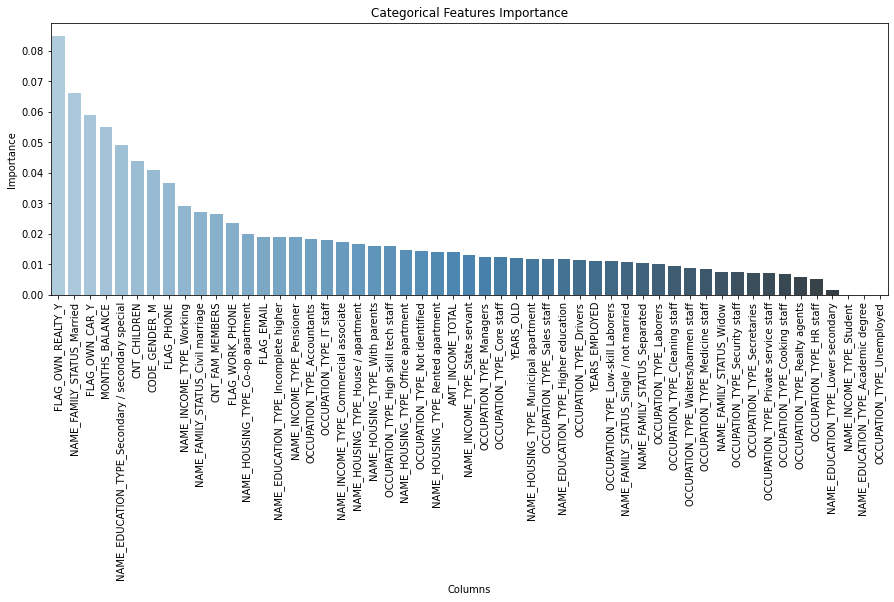

In [22]:
indices = np.argsort(modelxgb.feature_importances_)[::-1]

features = []
for i in range(len(X_train.columns)):
    features.append(X_train.columns[indices[i]])

fig, ax = plt.subplots(figsize=(15,5))     

sns.barplot(x=features, y=modelxgb.feature_importances_[indices[range(len(X_train.columns))]],\
label="Importtant Categorical Features", palette=("Blues_d"),ax=ax).\
set_title('Categorical Features Importance')

ax.set(xlabel="Columns", ylabel = "Importance")
plt.xticks(rotation='vertical')
plt.show()


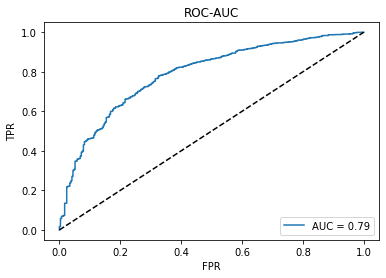

In [23]:
precision, recall, th = metrics.roc_curve(y_test, prediction)
roc_auc = metrics.auc(precision, recall)
display = metrics.RocCurveDisplay(fpr=precision, tpr=recall, roc_auc=roc_auc)

display.plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC")

plt.show()

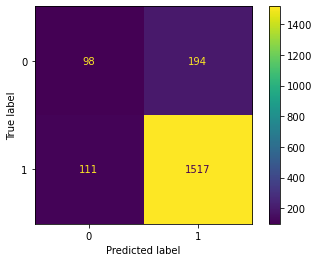

In [24]:
ConfMatrix = confusion_matrix(y_test, XGBprediction)
disp = ConfusionMatrixDisplay(confusion_matrix=ConfMatrix)
disp.plot()

# Feed Forward Neural Network #

[0.7138388770216662, 0.9596429661275557, 0.952471772963076]
[0.6703125, 0.8411458333333334, 0.765625]
##### SVC with linear kernel #####
              precision    recall  f1-score   support

         0.0       0.32      0.48      0.38       292
         1.0       0.90      0.82      0.86      1628

    accuracy                           0.77      1920
   macro avg       0.61      0.65      0.62      1920
weighted avg       0.81      0.77      0.78      1920
 

0.9412992939945561


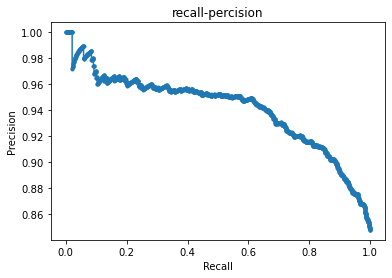

In [25]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation="relu",solver = 'sgd', random_state=1)
# I had trained this one first and retraining it takes way too long I just record the best params and am using that.
#clf_tuned = MLPClassifier(activation="relu",hidden_layer_sizes=(50, 25), learning_rate_init=0.1, max_iter=250,
              #random_state=1, solver='sgd')
#hidden_layer_sizes = [(25,5),(50,25), (50,33,11)]
#learning_rate_init = [ 0.1,.2,0.3]
#max_iter = [250,300,350]

#param_grid={'hidden_layer_sizes': hidden_layer_sizes,
#            'learning_rate_init': learning_rate_init,
#            'max_iter': max_iter,}
#clf_tuned=GridSearchCV(clf, param_grid, verbose=2, cv=10)

clf_tuned = MLPClassifier(activation="relu",hidden_layer_sizes=(50, 25), learning_rate_init=0.1, max_iter=250,
              random_state=1, solver='sgd')
clf_tuned.fit(X_train_scaled, y_train)
FNNprediction=clf_tuned.predict(X_test_scaled)
#clf_tuned.best_estimator_.fit(X_train, np.asarray(y_train))
trains_scores.append(clf_tuned.score(X_train_scaled, y_train))
tests_scores.append(clf_tuned.score(X_test_scaled, y_test))
print(trains_scores)
print(tests_scores)
#print(clf_tuned.best_estimator_)
print('##### SVC with linear kernel #####')
print(classification_report(y_test, FNNprediction), '\n')

prediction = model.predict_proba(X_test_scaled)[:,1]
print(average_precision_score(y_test, prediction))
precision, recall, th = precision_recall_curve(y_test, prediction)
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("recall-percision")

plt.show()


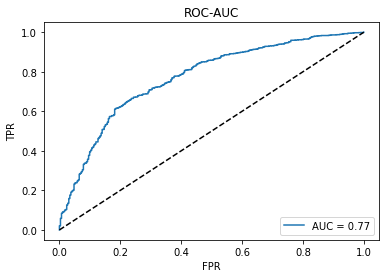

In [26]:
precision, recall, th = metrics.roc_curve(y_test, prediction)
roc_auc = metrics.auc(precision, recall)
display = metrics.RocCurveDisplay(fpr=precision, tpr=recall, roc_auc=roc_auc)

display.plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC")

plt.show()

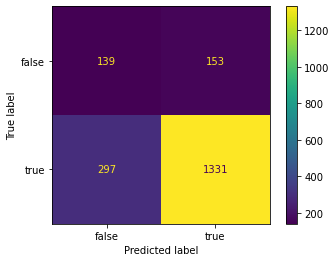

In [27]:
ConfMatrix = confusion_matrix(y_test, FNNprediction)
disp = ConfusionMatrixDisplay(confusion_matrix=ConfMatrix, display_labels=['false','true'])
disp.plot()

# RBF Support Vector Machine #

##### SVC with RBF kernel #####
              precision    recall  f1-score   support

         0.0       0.35      0.40      0.38       292
         1.0       0.89      0.87      0.88      1628

    accuracy                           0.80      1920
   macro avg       0.62      0.63      0.63      1920
weighted avg       0.81      0.80      0.80      1920

[0.7138388770216662, 0.9596429661275557, 0.952471772963076, 0.9685688129386634]
[0.6703125, 0.8411458333333334, 0.765625, 0.7973958333333333]
0.9325455055456352


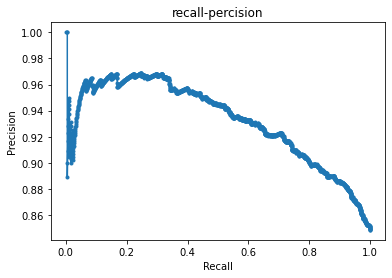

In [28]:
from sklearn.svm import SVC, LinearSVC

from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import reciprocal, uniform

# best params after training with below data
clf_non = SVC(C=150, gamma=0.1,kernel = 'rbf', probability=True) 

# previous training code
# training took about 2 and a half hours, if you wish to run this uncomment it and run it 
#clf_non = SVC(probability=True) # gamma

#param_grid = {'C': [0.1, 1, 10, 100, 150, 200],
#              'gamma': [1,0.5, 0.1,.05, 0.01, 0.001, 0.0001],
#              'kernel': ['rbf'],}
#clf_non =GridSearchCV(clf_non, param_grid, verbose = 2)


clf_non.fit(X_train_scaled, np.asarray(y_train))
RBFprediction=clf_non.predict(X_test_scaled)
# rbf SVM
print('##### SVC with RBF kernel #####')
print(classification_report(y_test, RBFprediction))
trains_scores.append(clf_non.score(X_train_scaled, y_train))
tests_scores.append(clf_non.score(X_test_scaled, y_test))
print(trains_scores)
print(tests_scores)

prediction = clf_non.predict_proba(X_test_scaled)[:,1]
print(average_precision_score(y_test, prediction))

precision, recall, th = precision_recall_curve(y_test, prediction)
plt.plot(recall, precision, marker='.')



plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("recall-percision")

plt.show()

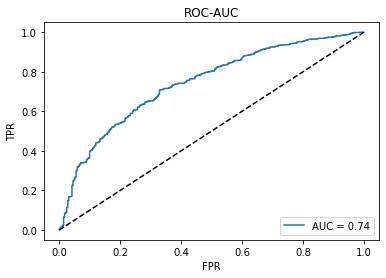

In [29]:
precision, recall, th = metrics.roc_curve(y_test, prediction)
roc_auc = metrics.auc(precision, recall)
display = metrics.RocCurveDisplay(fpr=precision, tpr=recall, roc_auc=roc_auc)

display.plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC")

plt.show()

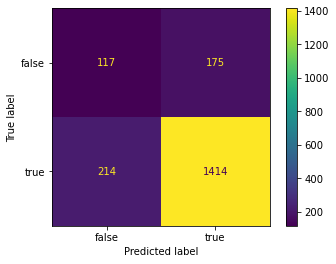

In [30]:
ConfMatrix = confusion_matrix(y_test, RBFprediction)
disp = ConfusionMatrixDisplay(confusion_matrix=ConfMatrix, display_labels=['false','true'])
disp.plot()

# Linear Support Vector Machine #

##### SVC with linear kernel #####
              precision    recall  f1-score   support

         0.0       0.28      0.79      0.41       292
         1.0       0.94      0.63      0.76      1628

    accuracy                           0.66      1920
   macro avg       0.61      0.71      0.58      1920
weighted avg       0.84      0.66      0.70      1920
 

[0.7138388770216662, 0.9596429661275557, 0.952471772963076, 0.9685688129386634, 0.7147543484894721]
[0.6703125, 0.8411458333333334, 0.765625, 0.7973958333333333, 0.6552083333333333]
0.9414017505362656


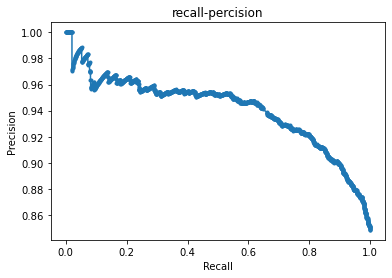

In [31]:

plt.clf()
#Best after training
clf = SVC(C=10, kernel='linear', probability=True)
#clf = SVC(kernel='linear',probability=True)

#param_distributions = { "C": [0.1, 1, 10] }

#clf=GridSearchCV(clf, param_distributions, verbose = 2)

clf.fit(X_train_scaled, np.asarray(y_train))
LSVMprediction=clf.predict(X_test_scaled)
# linear svm
print('##### SVC with linear kernel #####')
print(classification_report(y_test, LSVMprediction), '\n')
#print(clf.best_estimator_)
trains_scores.append(clf.score(X_train_scaled, y_train))
tests_scores.append(clf.score(X_test_scaled, y_test))
print(trains_scores)
print(tests_scores)
prediction = clf.predict_proba(X_test_scaled)[:,1]
print(average_precision_score(y_test, prediction))

precision, recall, th = precision_recall_curve(y_test, prediction)
plt.plot(recall, precision, marker='.')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("recall-percision")

plt.show()


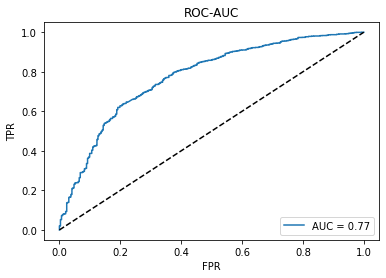

In [32]:
precision, recall, th = metrics.roc_curve(y_test, prediction)
roc_auc = metrics.auc(precision, recall)
display = metrics.RocCurveDisplay(fpr=precision, tpr=recall, roc_auc=roc_auc)

display.plot()

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC")
plt.show()

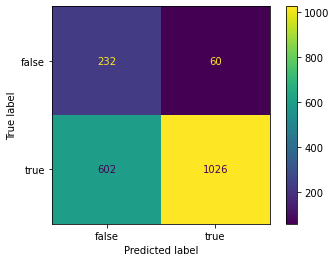

In [33]:
ConfMatrix = confusion_matrix(y_test, LSVMprediction)
disp = ConfusionMatrixDisplay(confusion_matrix=ConfMatrix, display_labels=['false','true'])
disp.plot()

In [34]:
import pickle
with open('modelxgb.pkl','wb') as f:
    pickle.dump(modelxgb,f)
    
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)
